In [17]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn')
from datetime import datetime
import numpy as np
from math import sin, pi

seq_len = 200

In [18]:
df = pd.read_csv('./s&p500_3years.csv', delimiter=',')
# Convert str to datetime in column "date"
df["date"] = pd.Series([datetime.strptime(x[:-6], "%Y-%m-%d %H:%M:%S") for x in df["date"]])
df.head()

,date,open,high,low,close,volume,is_ext
0,2018-04-02 13:00:00,190,190,188,189,9892,False
1,2018-04-02 14:00:00,188,188,186,186,34335,False
2,2018-04-02 15:00:00,186,186,184,185,35470,True
3,2018-04-02 16:00:00,185,187,184,185,25025,False
4,2018-04-02 17:00:00,185,186,184,184,23102,True


In [19]:
df["day_of_week"] = df["date"].apply(lambda x: sin(2*pi * x.weekday() / 7))
# df['day_of_year'] = df['date'].apply(lambda x: sin(2*pi * x.timetuple().tm_yday / 365))
df['time_of_day'] = df['date'].apply(lambda x: sin(2*pi*((x.time().hour - 7) * 60 + x.time().minute) / (15*60)))
df.head()

,date,open,high,low,close,volume,is_ext
0,2018-04-02 13:00:00,190,190,188,189,9892,False
1,2018-04-02 14:00:00,188,188,186,186,34335,False
2,2018-04-02 15:00:00,186,186,184,185,35470,True
3,2018-04-02 16:00:00,185,187,184,185,25025,False
4,2018-04-02 17:00:00,185,186,184,184,23102,True


In [20]:
'''Normalize price columns'''

df['open'] = (df['open']-np.mean(df['open']))/np.std(df['open'])
df['high'] = (df['high']-np.mean(df['high']))/np.std(df['high'])
df['low'] = (df['low']-np.mean(df['low']))/np.std(df['low']) 
df['close'] = (df['close']-np.mean(df['close']))/np.std(df['close'])
df['volume'] = (df['volume']-np.mean(df['volume']))/np.std(df['volume'])

df.head()

,date,open,high,low,close,volume,is_ext
0,2018-04-02 13:00:00,-1.507780,-1.515642,-1.522882,-1.519477,-0.342147,False
1,2018-04-02 14:00:00,-1.531133,-1.538941,-1.546295,-1.554513,0.777023,False
2,2018-04-02 15:00:00,-1.554485,-1.562241,-1.569708,-1.566192,0.828991,True
3,2018-04-02 16:00:00,-1.566162,-1.550591,-1.569708,-1.566192,0.350747,False
4,2018-04-02 17:00:00,-1.566162,-1.562241,-1.569708,-1.577870,0.262698,True


### Разделим датасет на тренировочный, валидационный и тестовый

In [21]:
times = df.index.values
last_10pct = df.index.values[-int(0.1*len(times))] # Last 10% of series
last_20pct = df.index.values[-int(0.2*len(times))] # Last 20% of series

In [22]:
###############################################################################
'''Create training, validation and test split'''

df_train = df[(df.index < last_20pct)]  # Training data are 80% of total data
df_val = df[(df.index >= last_20pct) & (df.index < last_10pct)]
df_test = df[(df.index >= last_10pct)]

# Remove date column
df_train.drop(columns=['date', "is_ext"], inplace=True)
df_val.drop(columns=['date', "is_ext"], inplace=True)
df_test.drop(columns=['date', "is_ext"], inplace=True)

# Convert pandas columns into arrays
train_data = df_train.values
val_data = df_val.values
test_data = df_test.values
print('Training data shape: {}'.format(train_data.shape))
print('Validation data shape: {}'.format(val_data.shape))
print('Test data shape: {}'.format(test_data.shape))

Training data shape: (8761, 5)
Validation data shape: (1095, 5)
Test data shape: (1095, 5)


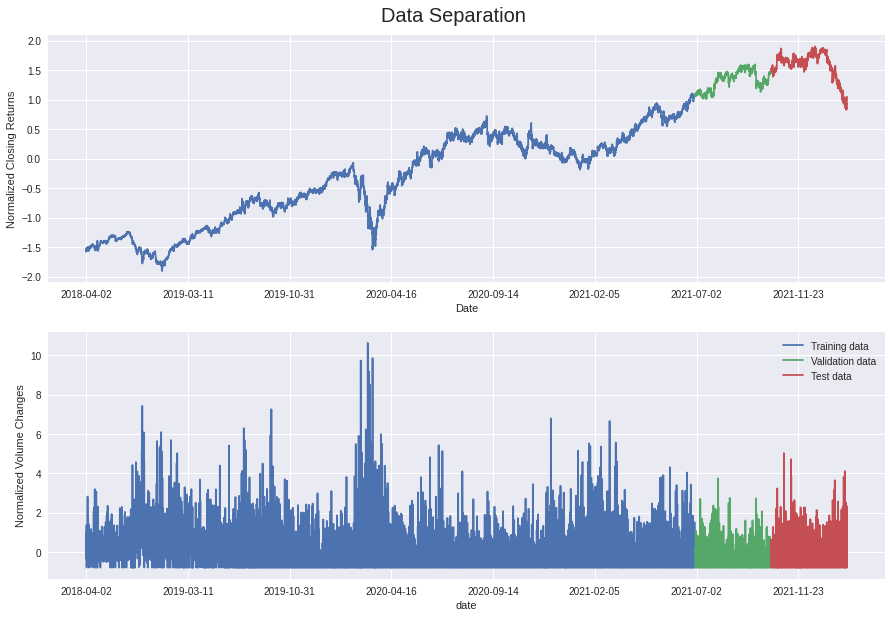

In [23]:
fig = plt.figure(figsize=(15,10))
st = fig.suptitle("Data Separation", fontsize=20)
st.set_y(0.92)

###############################################################################

ax1 = fig.add_subplot(211)
ax1.plot(np.arange(train_data.shape[0]), df_train['close'], label='Training data')

ax1.plot(np.arange(train_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]), df_val['close'], label='Validation data')

ax1.plot(np.arange(train_data.shape[0]+val_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]+test_data.shape[0]), df_test['close'], label='Test data')
ax1.set_xlabel('Date')
ax1.set_ylabel('Normalized Closing Returns')

ax1.set_xticks(range(0, df.shape[0], 1464))
ax1.set_xticklabels([y.date() for y in df['date'].loc[::1464]])

###############################################################################

ax2 = fig.add_subplot(212)
ax2.plot(np.arange(train_data.shape[0]), df_train['volume'], label='Training data')

ax2.plot(np.arange(train_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]), df_val['volume'], label='Validation data')

ax2.plot(np.arange(train_data.shape[0]+val_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]+test_data.shape[0]), df_test['volume'], label='Test data')
ax2.set_xlabel('date')
ax2.set_ylabel('Normalized Volume Changes')
ax2.set_xticks(range(0, df.shape[0], 1464))
ax2.set_xticklabels([y.date() for y in df['date'].loc[::1464]])

plt.legend(loc='best')
plt.savefig("data_sep_1_hour.png", dpi=300)
plt.show()

In [24]:
# Training data
X_train, y_train = [], []
for i in range(seq_len, len(train_data)):
  X_train.append(train_data[i-seq_len:i]) # Chunks of training data with a length of [seq_len] df-rows
  y_train.append(train_data[:, 3][i]) #Value of 4th column (Close Price) of df-row [seq_len + 1]
X_train, y_train = np.array(X_train), np.array(y_train)

###############################################################################

# Validation data
X_val, y_val = [], []
for i in range(seq_len, len(val_data)):
    X_val.append(val_data[i-seq_len:i])
    y_val.append(val_data[:, 3][i])
X_val, y_val = np.array(X_val), np.array(y_val)

###############################################################################

# Test data
X_test, y_test = [], []
for i in range(seq_len, len(test_data)):
    X_test.append(test_data[i-seq_len:i])
    y_test.append(test_data[:, 3][i])    
X_test, y_test = np.array(X_test), np.array(y_test)

## Создание и обучение модели

In [25]:
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
print('Tensorflow version: {}'.format(tf.__version__))
import warnings
warnings.filterwarnings('ignore')

Tensorflow version: 2.6.0


In [26]:
def create_model():
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.LSTM(64, input_shape=(seq_len, 5), return_sequences=True))
  model.add(tf.keras.layers.LSTM(64, return_sequences=True))
  model.add(tf.keras.layers.LSTM(32))
  model.add(tf.keras.layers.Dense(1))#, activation=tf.nn.relu))
  model.compile(optimizer="adam", loss="mean_squared_error")
  return model

### Обучение

In [27]:
model = create_model()

model.summary()

model.fit(X_train, y_train,
              batch_size=1024,
              epochs=50,
              validation_data=(X_val, y_val),)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 200, 64)           17920     
_________________________________________________________________
lstm_4 (LSTM)                (None, 200, 64)           33024     
_________________________________________________________________
lstm_5 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 63,393
Trainable params: 63,393
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
9/9 [==============================] - 16s 1s/step - loss: 0.3365 - val_loss: 0.3425
Epoch 2/50
9/9 [==============================] - 13s 1s/step - loss: 0.0604 - val_loss: 0.3277
Epoch 3/50
9/9 [==============================] - 13s 1s

In [28]:
# Get predictions
train_pred = model.predict(X_train)
val_pred = model.predict(X_val)
test_pred = model.predict(X_test)

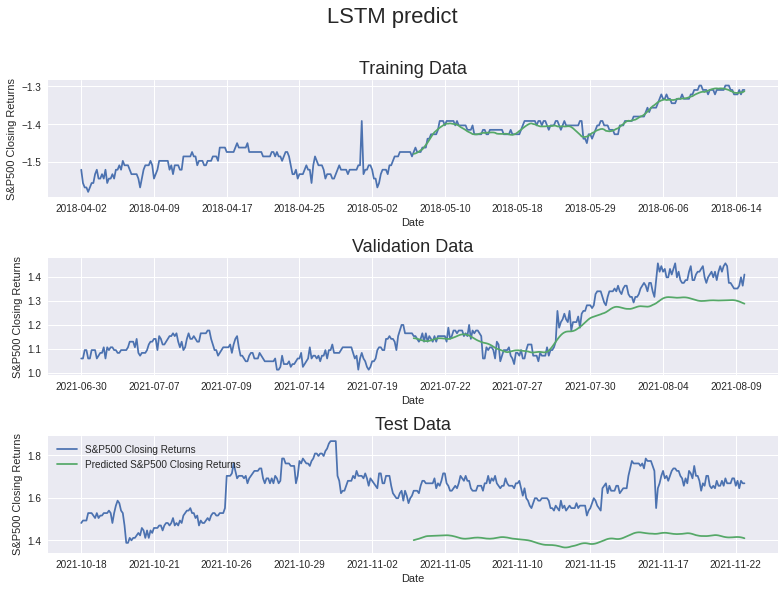

In [29]:
'''Display results'''

fig = plt.figure(figsize=(11,8))
st = fig.suptitle("LSTM predict", fontsize=22)
st.set_y(1.02)

#Plot training data results
ax11 = fig.add_subplot(311)
ax11.plot(train_data[:int(2*(seq_len-8)), 3], label='S&P500 Closing Returns')
ax11.plot(np.arange(seq_len-8, int(2*(seq_len-8))), train_pred[:(seq_len-8)], label='Predicted S&P500 Closing Returns')
ax11.set_title("Training Data", fontsize=18)
ax11.set_xlabel('Date')
ax11.set_ylabel('S&P500 Closing Returns')
ax11.set_xticks(range(0, int(2*(seq_len-8)), 42))
ax11.set_xticklabels([y.date() for y in df['date'].loc[:int(2*(seq_len-8)):42]])

#Plot validation data results
ax21 = fig.add_subplot(312)
ax21.plot(val_data[:int(2*(seq_len-8)), 3], label='S&P500 Closing Returns')
ax21.plot(np.arange(seq_len-8, int(2*(seq_len-8))),val_pred[:(seq_len-8)], label='Predicted S&P500 Closing Returns')
ax21.set_title("Validation Data", fontsize=18)
ax21.set_xlabel('Date')
ax21.set_ylabel('S&P500 Closing Returns')
ax21.set_xticks(range(0, int(2*(seq_len-8)), 42))
ax21.set_xticklabels([y.date() for y in df['date'].loc[last_20pct:last_20pct+ int(2*(seq_len-8)):42]])

#Plot test data results
ax31 = fig.add_subplot(313)
ax31.plot(test_data[:int(2*(seq_len-8)), 3], label='S&P500 Closing Returns')
ax31.plot(np.arange(seq_len-8, int(2*(seq_len-8))),test_pred[:(seq_len-8)], label='Predicted S&P500 Closing Returns')
ax31.set_title("Test Data", fontsize=18)
ax31.set_xlabel('Date')
ax31.set_ylabel('S&P500 Closing Returns')
ax31.set_xticks(range(0, int(2*(seq_len-8)), 42))
ax31.set_xticklabels([y.date() for y in df['date'].loc[last_10pct:last_10pct + int(2*(seq_len-8)):42]])
 
plt.tight_layout()
plt.legend(loc='best')
plt.savefig("predict_200_50ep.png", dpi=300)
plt.show()

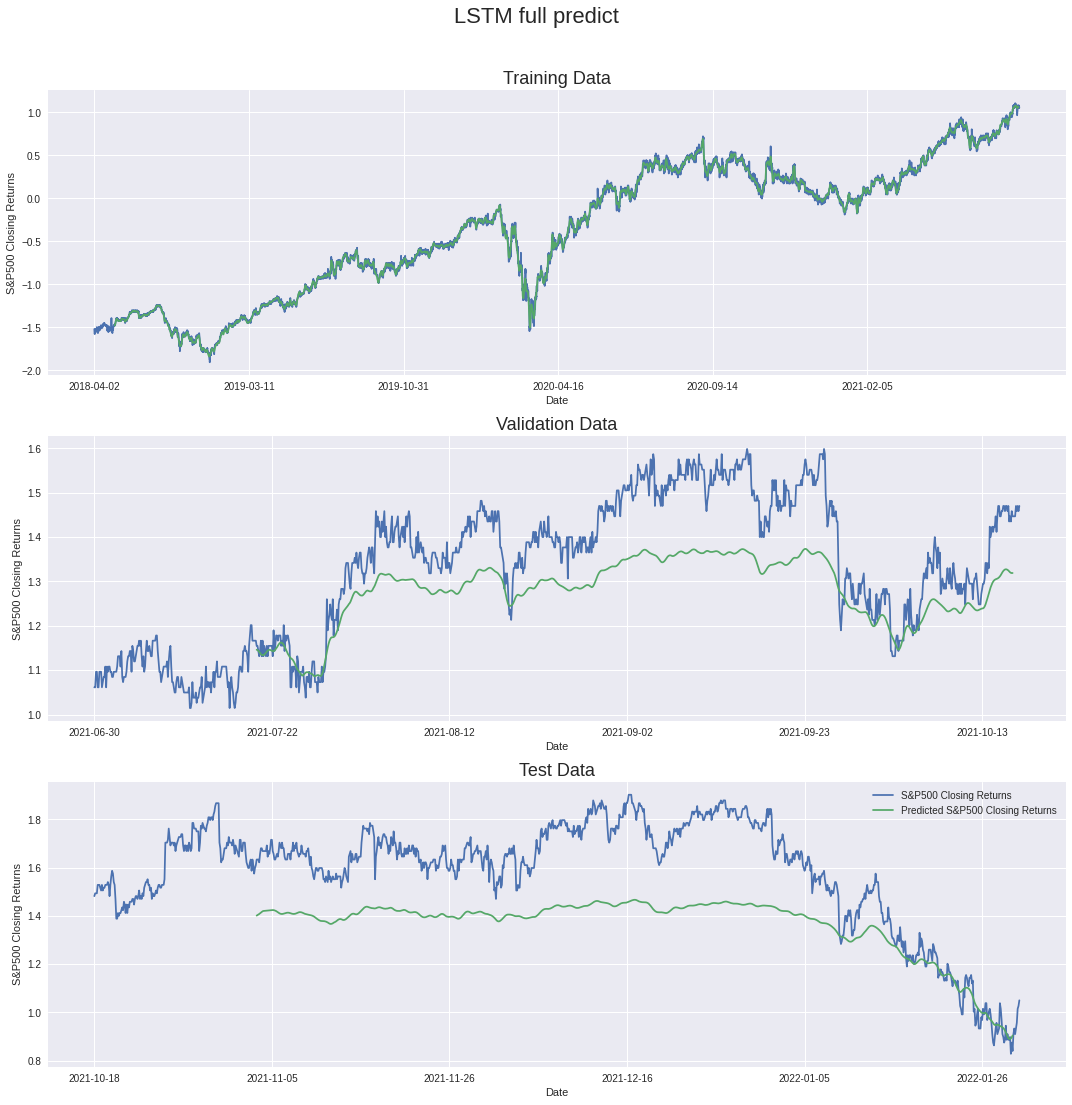

In [30]:
'''Display results'''

fig = plt.figure(figsize=(15,15))
st = fig.suptitle("LSTM full predict", fontsize=22)
st.set_y(1.02)

#Plot training data results
ax11 = fig.add_subplot(311)
ax11.plot(train_data[:, 3], label='S&P500 Closing Returns')
ax11.plot(np.arange(seq_len-8, train_pred.shape[0]+seq_len-8),train_pred, label='Predicted S&P500 Closing Returns')
ax11.set_title("Training Data", fontsize=18)
ax11.set_xlabel('Date')
ax11.set_ylabel('S&P500 Closing Returns')
ax11.set_xticks(range(0, df[:last_20pct].shape[0], 1464))
ax11.set_xticklabels([y.date() for y in df['date'].loc[:last_20pct:1464]])

#Plot validation data results
ax21 = fig.add_subplot(312)
ax21.plot(val_data[:, 3], label='S&P500 Closing Returns')
ax21.plot(np.arange(seq_len-8, val_pred.shape[0]+seq_len-8),val_pred, label='Predicted S&P500 Closing Returns')
ax21.set_title("Validation Data", fontsize=18)
ax21.set_xlabel('Date')
ax21.set_ylabel('S&P500 Closing Returns')
ax21.set_xticks(range(0, df[last_20pct:last_10pct].shape[0], 210))
ax21.set_xticklabels([y.date() for y in df['date'].loc[last_20pct:last_10pct:210]])

#Plot test data results
ax31 = fig.add_subplot(313)
ax31.plot(test_data[:, 3], label='S&P500 Closing Returns')
ax31.plot(np.arange(seq_len-8, test_pred.shape[0]+seq_len-8), test_pred, label='Predicted S&P500 Closing Returns')
ax31.set_title("Test Data", fontsize=18)
ax31.set_xlabel('Date')
ax31.set_ylabel('S&P500 Closing Returns')
ax31.set_xticks(range(0, df[last_10pct:].shape[0], 210))
ax31.set_xticklabels([y.date() for y in df['date'].loc[last_10pct::210]])
 
plt.tight_layout()
plt.legend(loc='best')
plt.savefig("full_predict_200_50ep.png", dpi=300)
plt.show()

In [31]:
kernel_size = 7
test_true = test_data[seq_len-8:, 3]
lim = 0.005

true_ext_count = 0
pred_ext_count = 0

converges = 0
false_conv = 0

for i in range(len(test_true) // kernel_size - 1):
    kern_true = test_true[i*kernel_size: (i+1)*kernel_size]
    
    flag1 = False
    flag2 = False
    
    # Если в окне ИСТИННОГО ДС был скачок более, чем на lim%
    if (np.max(kern_true) / np.min(kern_true) - 1) > lim:
        true_ext_count += 1
        flag1 = True
    
    kern_pred = test_pred[i*kernel_size: (i+1)*kernel_size]
    # Если в окне ПРЕДСКАЗАННОГО ДС был скачок более, чем на lim%
    if (np.max(kern_pred) / np.min(kern_pred) - 1) > lim:
        pred_ext_count += 1
        flag2 = True
    
    converges += flag1 and flag2
    
    false_conv += flag1 != flag2
    
print(true_ext_count, pred_ext_count, converges, false_conv)

128 69 69 59


# Попробуем поиграться с параметрами

In [87]:
seq_len = 300

df = pd.read_csv('./s&p500_3years.csv', delimiter=',')
# Convert str to datetime in column "date"
df["date"] = pd.Series([datetime.strptime(x[:-6], "%Y-%m-%d %H:%M:%S") for x in df["date"]])
df.head()

,date,open,high,low,close,volume,is_ext
0,2018-04-02 13:00:00,190,190,188,189,9892,False
1,2018-04-02 14:00:00,188,188,186,186,34335,False
2,2018-04-02 15:00:00,186,186,184,185,35470,True
3,2018-04-02 16:00:00,185,187,184,185,25025,False
4,2018-04-02 17:00:00,185,186,184,184,23102,True


In [88]:
# df["day_of_week"] = df["date"].apply(lambda x: sin(2*pi * x.weekday() / 7))
# df['day_of_year'] = df['date'].apply(lambda x: sin(2*pi * x.timetuple().tm_yday / 365))
# df['time_of_day'] = df['date'].apply(lambda x: sin(2*pi*((x.time().hour - 7) * 60 + x.time().minute) / (15*60)))
'''Normalize price columns'''

df['open'] = (df['open']-np.mean(df['open']))/np.std(df['open'])
df['high'] = (df['high']-np.mean(df['high']))/np.std(df['high'])
df['low'] = (df['low']-np.mean(df['low']))/np.std(df['low']) 
df['close'] = (df['close']-np.mean(df['close']))/np.std(df['close'])
df['volume'] = (df['volume']-np.mean(df['volume']))/np.std(df['volume'])

df.head()

,date,open,high,low,close,volume,is_ext
0,2018-04-02 13:00:00,-1.507780,-1.515642,-1.522882,-1.519477,-0.342147,False
1,2018-04-02 14:00:00,-1.531133,-1.538941,-1.546295,-1.554513,0.777023,False
2,2018-04-02 15:00:00,-1.554485,-1.562241,-1.569708,-1.566192,0.828991,True
3,2018-04-02 16:00:00,-1.566162,-1.550591,-1.569708,-1.566192,0.350747,False
4,2018-04-02 17:00:00,-1.566162,-1.562241,-1.569708,-1.577870,0.262698,True


In [89]:
times = df.index.values
last_10pct = df.index.values[-int(0.1*len(times))] # Last 10% of series
last_20pct = df.index.values[-int(0.2*len(times))] # Last 20% of series

In [90]:
###############################################################################
'''Create training, validation and test split'''

df_train = df[(df.index < last_20pct)]  # Training data are 80% of total data
df_val = df[(df.index >= last_20pct) & (df.index < last_10pct)]
df_test = df[(df.index >= last_10pct)]

# Remove date column
df_train.drop(columns=['date', "is_ext"], inplace=True)
df_val.drop(columns=['date', "is_ext"], inplace=True)
df_test.drop(columns=['date', "is_ext"], inplace=True)

# Convert pandas columns into arrays
train_data = df_train.values
val_data = df_val.values
test_data = df_test.values
print('Training data shape: {}'.format(train_data.shape))
print('Validation data shape: {}'.format(val_data.shape))
print('Test data shape: {}'.format(test_data.shape))

Training data shape: (8761, 5)
Validation data shape: (1095, 5)
Test data shape: (1095, 5)


In [91]:
# Training data
X_train, y_train = [], []
for i in range(seq_len, len(train_data)):
  X_train.append(train_data[i-seq_len:i]) # Chunks of training data with a length of [seq_len] df-rows
  y_train.append(train_data[:, 3][i]) #Value of 4th column (Close Price) of df-row [seq_len + 1]
X_train, y_train = np.array(X_train), np.array(y_train)

###############################################################################

# Validation data
X_val, y_val = [], []
for i in range(seq_len, len(val_data)):
    X_val.append(val_data[i-seq_len:i])
    y_val.append(val_data[:, 3][i])
X_val, y_val = np.array(X_val), np.array(y_val)

###############################################################################

# Test data
X_test, y_test = [], []
for i in range(seq_len, len(test_data)):
    X_test.append(test_data[i-seq_len:i])
    y_test.append(test_data[:, 3][i])    
X_test, y_test = np.array(X_test), np.array(y_test)

In [92]:
def create_model():
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.LSTM(64, input_shape=(seq_len, 5), return_sequences=True))
  model.add(tf.keras.layers.LSTM(64, return_sequences=True))
  model.add(tf.keras.layers.LSTM(32))
  model.add(tf.keras.layers.Dense(1))#, activation=tf.nn.relu))
  model.compile(optimizer="adam", loss="mean_squared_error")
  return model

In [93]:
model = create_model()

model.summary()

model.fit(X_train, y_train,
              batch_size=1024,
              epochs=50,
              validation_data=(X_val, y_val),)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_21 (LSTM)               (None, 300, 64)           17920     
_________________________________________________________________
lstm_22 (LSTM)               (None, 300, 64)           33024     
_________________________________________________________________
lstm_23 (LSTM)               (None, 32)                12416     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 33        
Total params: 63,393
Trainable params: 63,393
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
9/9 [==============================] - 25s 2s/step - loss: 0.2141 - val_loss: 0.1277
Epoch 2/50
9/9 [==============================] - 19s 2s/step - loss: 0.0417 - val_loss: 0.3573
Epoch 3/50
9/9 [==============================] - 19s 2s

In [94]:
# Get predictions
train_pred = model.predict(X_train)
val_pred = model.predict(X_val)
test_pred = model.predict(X_test)

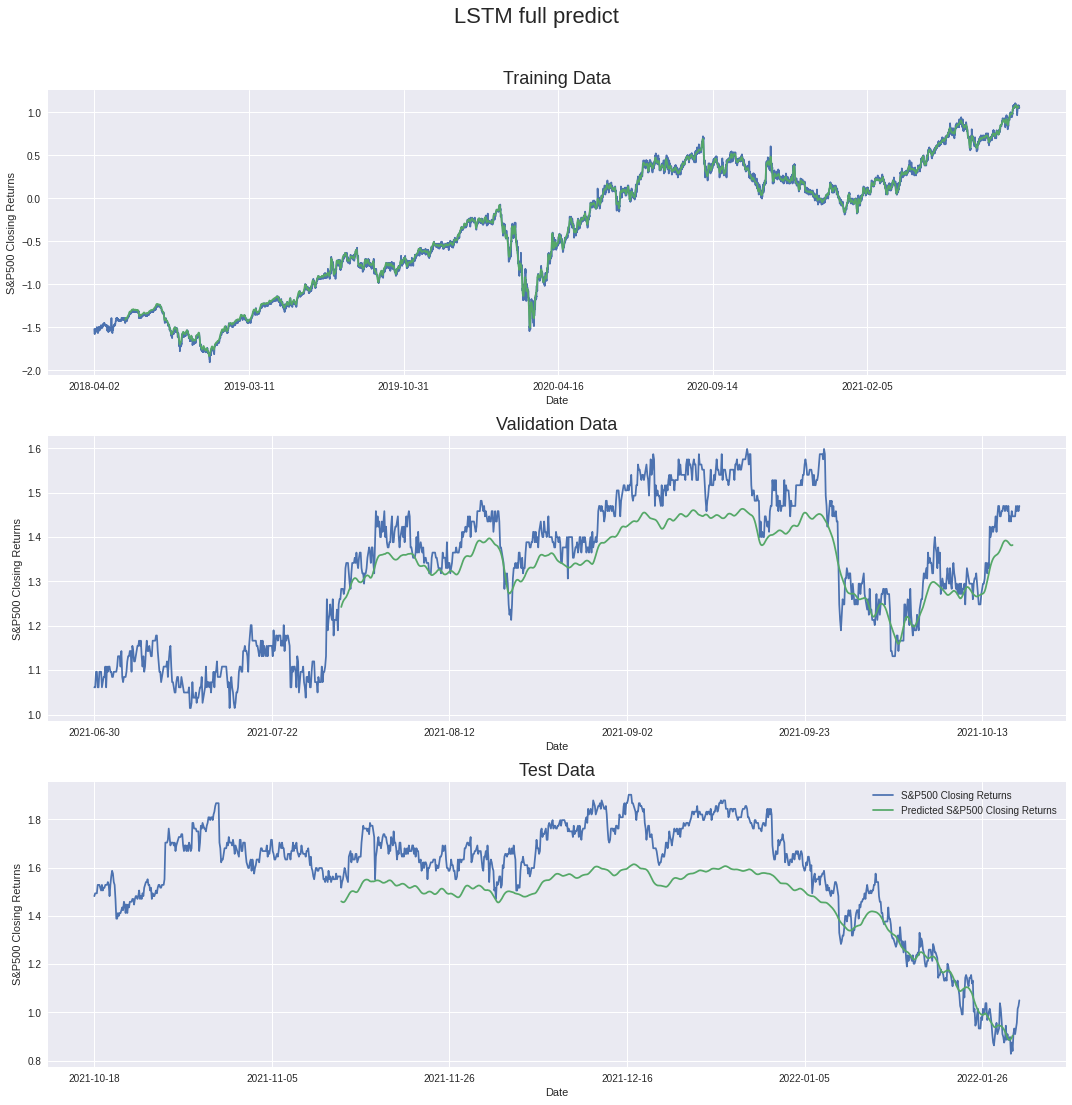

In [95]:
'''Display results'''

fig = plt.figure(figsize=(15,15))
st = fig.suptitle("LSTM full predict", fontsize=22)
st.set_y(1.02)

#Plot training data results
ax11 = fig.add_subplot(311)
ax11.plot(train_data[:, 3], label='S&P500 Closing Returns')
ax11.plot(np.arange(seq_len-8, train_pred.shape[0]+seq_len-8),train_pred, label='Predicted S&P500 Closing Returns')
ax11.set_title("Training Data", fontsize=18)
ax11.set_xlabel('Date')
ax11.set_ylabel('S&P500 Closing Returns')
ax11.set_xticks(range(0, df[:last_20pct].shape[0], 1464))
ax11.set_xticklabels([y.date() for y in df['date'].loc[:last_20pct:1464]])

#Plot validation data results
ax21 = fig.add_subplot(312)
ax21.plot(val_data[:, 3], label='S&P500 Closing Returns')
ax21.plot(np.arange(seq_len-8, val_pred.shape[0]+seq_len-8),val_pred, label='Predicted S&P500 Closing Returns')
ax21.set_title("Validation Data", fontsize=18)
ax21.set_xlabel('Date')
ax21.set_ylabel('S&P500 Closing Returns')
ax21.set_xticks(range(0, df[last_20pct:last_10pct].shape[0], 210))
ax21.set_xticklabels([y.date() for y in df['date'].loc[last_20pct:last_10pct:210]])

#Plot test data results
ax31 = fig.add_subplot(313)
ax31.plot(test_data[:, 3], label='S&P500 Closing Returns')
ax31.plot(np.arange(seq_len-8, test_pred.shape[0]+seq_len-8), test_pred, label='Predicted S&P500 Closing Returns')
ax31.set_title("Test Data", fontsize=18)
ax31.set_xlabel('Date')
ax31.set_ylabel('S&P500 Closing Returns')
ax31.set_xticks(range(0, df[last_10pct:].shape[0], 210))
ax31.set_xticklabels([y.date() for y in df['date'].loc[last_10pct::210]])
 
plt.tight_layout()
plt.legend(loc='best')
plt.savefig("full_predict_300_50ep_no_date.png", dpi=300)
plt.show()

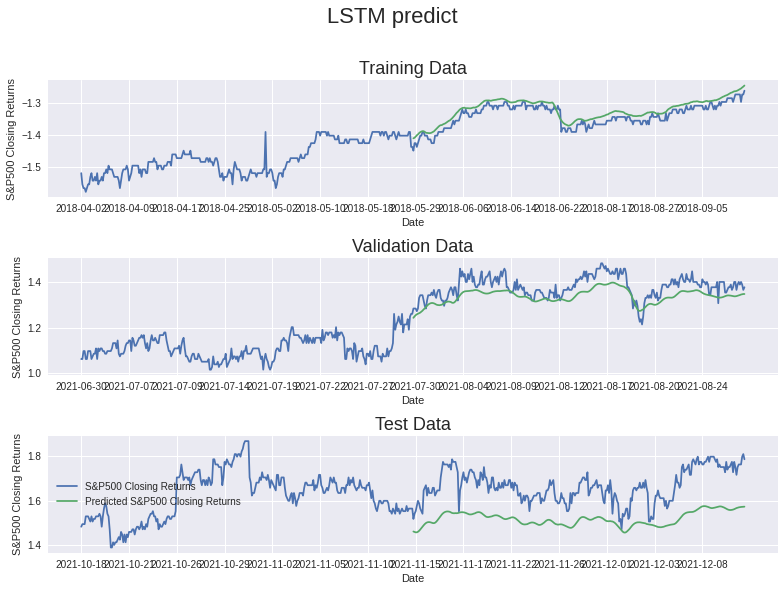

In [96]:
'''Display results'''

fig = plt.figure(figsize=(11,8))
st = fig.suptitle("LSTM predict", fontsize=22)
st.set_y(1.02)

#Plot training data results
ax11 = fig.add_subplot(311)
ax11.plot(train_data[:int(2*(seq_len-8)), 3], label='S&P500 Closing Returns')
ax11.plot(np.arange(seq_len-8, int(2*(seq_len-8))), train_pred[:(seq_len-8)], label='Predicted S&P500 Closing Returns')
ax11.set_title("Training Data", fontsize=18)
ax11.set_xlabel('Date')
ax11.set_ylabel('S&P500 Closing Returns')
ax11.set_xticks(range(0, int(2*(seq_len-8)), 42))
ax11.set_xticklabels([y.date() for y in df['date'].loc[:int(2*(seq_len-8)):42]])

#Plot validation data results
ax21 = fig.add_subplot(312)
ax21.plot(val_data[:int(2*(seq_len-8)), 3], label='S&P500 Closing Returns')
ax21.plot(np.arange(seq_len-8, int(2*(seq_len-8))),val_pred[:(seq_len-8)], label='Predicted S&P500 Closing Returns')
ax21.set_title("Validation Data", fontsize=18)
ax21.set_xlabel('Date')
ax21.set_ylabel('S&P500 Closing Returns')
ax21.set_xticks(range(0, int(2*(seq_len-8)), 42))
ax21.set_xticklabels([y.date() for y in df['date'].loc[last_20pct:last_20pct+ int(2*(seq_len-8)):42]])

#Plot test data results
ax31 = fig.add_subplot(313)
ax31.plot(test_data[:int(2*(seq_len-8)), 3], label='S&P500 Closing Returns')
ax31.plot(np.arange(seq_len-8, int(2*(seq_len-8))),test_pred[:(seq_len-8)], label='Predicted S&P500 Closing Returns')
ax31.set_title("Test Data", fontsize=18)
ax31.set_xlabel('Date')
ax31.set_ylabel('S&P500 Closing Returns')
ax31.set_xticks(range(0, int(2*(seq_len-8)), 42))
ax31.set_xticklabels([y.date() for y in df['date'].loc[last_10pct:last_10pct + int(2*(seq_len-8)):42]])
 
plt.tight_layout()
plt.legend(loc='best')
plt.savefig("predict_300_50ep_no_date.png", dpi=300)
plt.show()

In [97]:
kernel_size = 7
test_true = test_data[seq_len-8:, 3]
lim = 0.005

true_ext_count = 0
pred_ext_count = 0

converges = 0
false_conv = 0

for i in range(len(test_true) // kernel_size - 1):
    kern_true = test_true[i*kernel_size: (i+1)*kernel_size]
    
    flag1 = False
    flag2 = False
    
    # Если в окне ИСТИННОГО ДС был скачок более, чем на lim%
    if (np.max(kern_true) / np.min(kern_true) - 1) > lim:
        true_ext_count += 1
        flag1 = True
    
    kern_pred = test_pred[i*kernel_size: (i+1)*kernel_size]
    # Если в окне ПРЕДСКАЗАННОГО ДС был скачок более, чем на lim%
    if (np.max(kern_pred) / np.min(kern_pred) - 1) > lim:
        pred_ext_count += 1
        flag2 = True
    
    converges += flag1 and flag2
    
    false_conv += flag1 != flag2
    
print(true_ext_count, pred_ext_count, converges, false_conv)

113 75 75 38
